# Introduction

## Import

In [97]:
import os

In [98]:
import numpy as np

In [99]:
import pandas as pd

In [100]:
import seaborn as sns

In [101]:
import matplotlib.pyplot as plt

In [102]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

## Loading

In [103]:
DATA_PATH = "/content/fifa_players.csv"
OUTPUT_PATH = "kaggle_submissions/"

S_RANDOM_STATE = 3993    # Seed for train/test data splitting
M_RANDOM_STATE = 42      # Seed for RandomForest model training

TRAIN_SIZE = 0.75

In [104]:
df = pd.read_csv(DATA_PATH)

# Utility

In [105]:
def generateSubmission(myModel, submissionFile, description):
    # Read the test data
    data = pd.read_csv(DATA_PATH)
    Id, X_test= data.Id,data.drop(columns=DROPCOLUMS)
    # Impute each test item, then predict
    X_test_imp = imp.transform(X_test)

    # Use the model to make predictions
    y_test_pred = myModel.predict(X_test_imp)

    # submission file
    my_submission = pd.DataFrame({"Id": Id, "target": y_test_pred})

    if not os.path.exists(OUTPUT_PATH):
      os.mkdir(OUTPUT_PATH)

    # you could use any filename. We choose submission here
    my_submission.to_csv(OUTPUT_PATH, index=False)

    # Submit authomatically; kaggle API authentication needed
    #!kaggle competitions submit -c heart-attack-analysis-and-prediction-21 -f {OUTPUT_PATH/submissionFile} -m '{description}'

# Features Engineering

## Missing Values

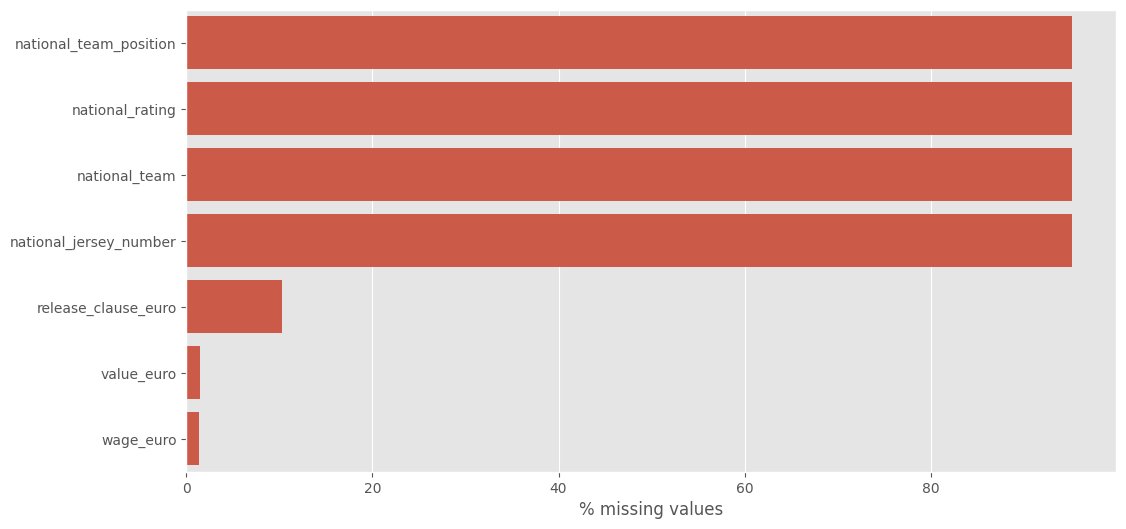

In [106]:
missing = df.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)
missing_pct = missing / len(df) * 100

plt.figure(figsize=(12, 6))
sns.barplot(x=missing_pct.values, y=missing_pct.index)
plt.xlabel("% missing values")
plt.ylabel("")
plt.show()

## Features

In [107]:
df_filtered = df[
    df['potential'].notna() & df['overall_rating'].notna()
    ].copy()

features=(df_filtered.columns)
print(features)

Index(['name', 'full_name', 'birth_date', 'age', 'height_cm', 'weight_kgs',
       'positions', 'nationality', 'overall_rating', 'potential', 'value_euro',
       'wage_euro', 'preferred_foot', 'international_reputation(1-5)',
       'weak_foot(1-5)', 'skill_moves(1-5)', 'body_type',
       'release_clause_euro', 'national_team', 'national_rating',
       'national_team_position', 'national_jersey_number', 'crossing',
       'finishing', 'heading_accuracy', 'short_passing', 'volleys',
       'dribbling', 'curve', 'freekick_accuracy', 'long_passing',
       'ball_control', 'acceleration', 'sprint_speed', 'agility', 'reactions',
       'balance', 'shot_power', 'jumping', 'stamina', 'strength', 'long_shots',
       'aggression', 'interceptions', 'positioning', 'vision', 'penalties',
       'composure', 'marking', 'standing_tackle', 'sliding_tackle'],
      dtype='object')


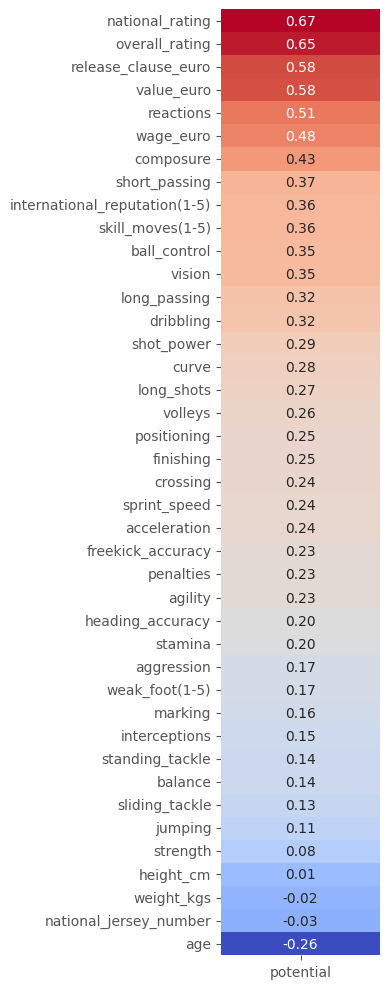

In [108]:
df_numeric = df.select_dtypes(include='number')
corr = df_numeric.corr()

features = corr['potential'].drop('potential').sort_values(ascending=False).index.tolist()

plt.figure(figsize=(4, 10))
sns.heatmap(corr.loc[features, ['potential']], annot=True, cmap='coolwarm', fmt=".2f", cbar=False)

plt.tight_layout()
plt.show()

## Aggregated Features

### 1. Growth Potential Index

Calculate growth potential based on player age and current abilities


In [109]:
df_filtered['growth_potential_index'] = np.where(

    # CONDITION 1: Very young players (age <= 23)
    df_filtered['age'] <= 23,
    # For very young: significant bonuses
    ((df_filtered['reactions'] * 0.65 + df_filtered['composure'] * 0.35) / 1.0) *
    (1 + (24 - df_filtered['age']) * 0.1 +  # Age bonus: younger = more bonus
     df_filtered['international_reputation(1-5)'] * 0.02),  # International reputation bonus

    np.where(
        # CONDITION 2: Young players (age 24-27)
        df_filtered['age'] <= 27,
        # For young: moderate age-only bonus
        ((df_filtered['reactions'] * 0.65 + df_filtered['composure'] * 0.35) / 1.0) *
        (1 + (28 - df_filtered['age']) * 0.05),  # Reduced age bonus

        # CONDITION 3: Mature players (age > 27)
        df_filtered['reactions'] * 0.65 + df_filtered['composure'] * 0.35
    )
)

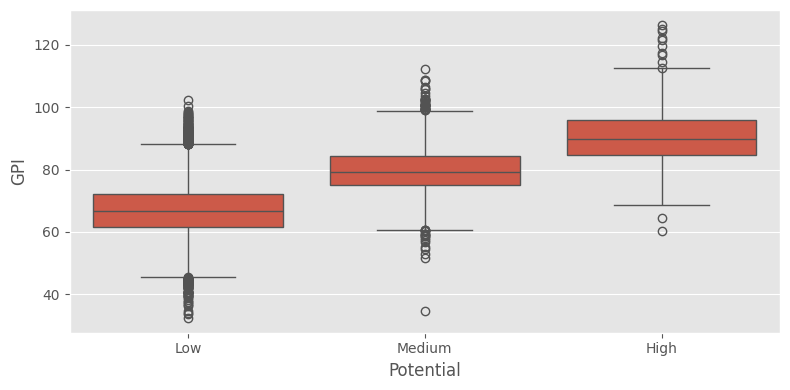

In [110]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (8, 4)

bins = [0, 76, 82, 100]
labels = ['Low', 'Medium', 'High']
df_filtered['potential_category'] = pd.cut(df_filtered['potential'], bins=bins, labels=labels)

sns.boxplot(x='potential_category', y='growth_potential_index', data=df_filtered)
plt.xlabel('Potential')
plt.ylabel('GPI')
plt.tight_layout()

### 2. Reaction Development

Normalize reaction stats based on age expectations with development multiplier


In [111]:
df_filtered['reaction_development'] = np.where(
    df_filtered['age'] <= 20, df_filtered['reactions'] / 53.6,  # Young talent benchmark
    np.where(df_filtered['age'] <= 25, df_filtered['reactions'] / 60.5,  # Developing player benchmark
    np.where(df_filtered['age'] <= 30, df_filtered['reactions'] / 65.3,  # Prime age benchmark
    df_filtered['reactions'] / 67.1))  # Veteran benchmark
) * 1.2

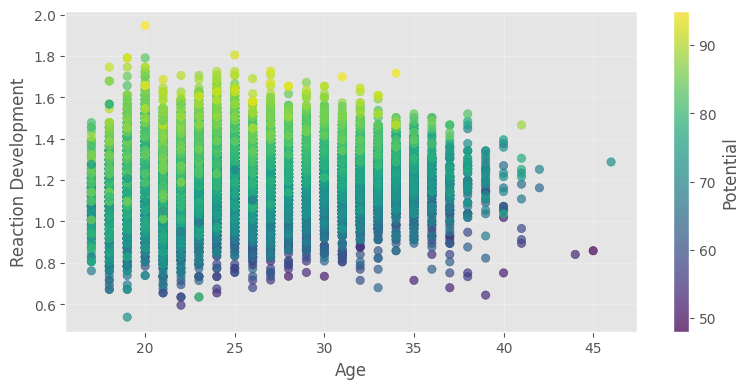

In [112]:
plt.scatter(df_filtered['age'], df_filtered['reaction_development'],
           c=df_filtered['potential'], cmap='viridis', alpha=0.7)
plt.colorbar(label='Potential')
plt.xlabel('Age')
plt.ylabel('Reaction Development')
plt.grid(True, alpha=0.3)
plt.tight_layout()

### 3. Role Quality

Extract main position and group into categories

In [113]:
df_filtered['main_position'] = df_filtered['positions'].str.split(',').str[0].str.strip()
position_groups = {
    'Attackers': ['ST', 'CF', 'LW', 'RW', 'LS', 'RS'],
    'Midfielders': ['CM', 'CAM', 'CDM', 'LM', 'RM'],
    'Defenders': ['CB', 'LB', 'RB', 'LWB', 'RWB'],
    'Goalkeepers': ['GK']
}

# Assign each player to a position group
df_filtered['position_group'] = df_filtered['main_position'].apply(
    lambda x: next((k for k, v in position_groups.items() if x in v), 'Other')
)

# Attacker quality: focus on scoring and dribbling abilities
df_filtered['attacker_quality'] = (
    df_filtered['dribbling'] * 0.25 +
    df_filtered['finishing'] * 0.25 +
    df_filtered['acceleration'] * 0.15 +
    df_filtered['positioning'] * 0.2 +
    df_filtered['reactions'] * 0.15
) / df_filtered['age']

# Midfielder quality: focus on passing and game control
df_filtered['midfielder_quality'] = (
    df_filtered['short_passing'] * 0.25 +
    df_filtered['vision'] * 0.25 +
    df_filtered['ball_control'] * 0.15 +
    df_filtered['stamina'] * 0.1 +
    df_filtered['interceptions'] * 0.15 +
    df_filtered['reactions'] * 0.1
) / df_filtered['age']

# Defender quality: focus on defensive fundamentals
df_filtered['defender_quality'] = (
    df_filtered['standing_tackle'] * 0.25 +
    df_filtered['interceptions'] * 0.25 +
    df_filtered['marking'] * 0.25 +
    df_filtered['strength'] * 0.15 +
    df_filtered['reactions'] * 0.1
) / df_filtered['age']

# Goalkeeper quality: focus on shot-stopping and composure
df_filtered['goalkeeper_quality'] = (
    df_filtered['reactions'] * 0.4 +
    df_filtered['composure'] * 0.3 +
    df_filtered['agility'] * 0.15 +
    df_filtered['jumping'] * 0.15
) / df_filtered['age']

In [114]:
df_filtered['role_quality'] = np.where(
    df_filtered['position_group'] == 'Attackers',
    df_filtered['attacker_quality'],
        np.where(
            df_filtered['position_group'] == 'Defenders',
            df_filtered['defender_quality'],
            np.where(
                df_filtered['position_group'] == 'Goalkeepers',
                df_filtered['goalkeeper_quality'],
                    df_filtered['midfielder_quality']  # default per 'Other'
        )
    )
)

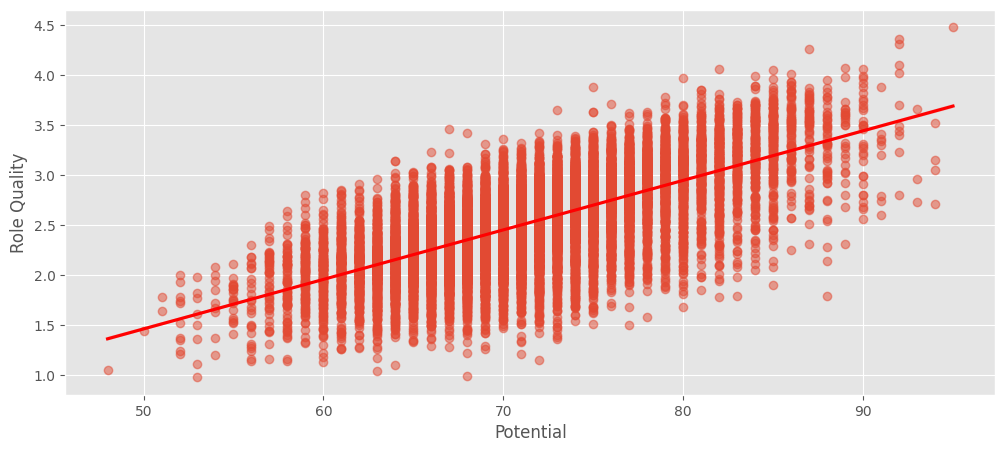

In [115]:
plt.figure(figsize=(12, 5))
sns.regplot(x='potential', y='role_quality', data=df_filtered, scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
plt.xlabel('Potential')
plt.ylabel('Role Quality')
plt.show()

### 4. Market Value



Feature considering multiple factors affecting player value

In [116]:
df_filtered['market_value'] = np.clip(
    np.sqrt(np.log1p(df_filtered['release_clause_euro'].fillna(df_filtered['value_euro'].fillna(0)))) / 15 *
    df_filtered['overall_rating'] / 150 *                                    # Current ability factor
    (1 + (28 - df_filtered['age'].clip(upper=28)) / 120) *                  # Age premium for young players
    (1 + df_filtered['international_reputation(1-5)'] * 0.05),
    0, 2  # Clip between 0 and 2 to prevent extreme values
)

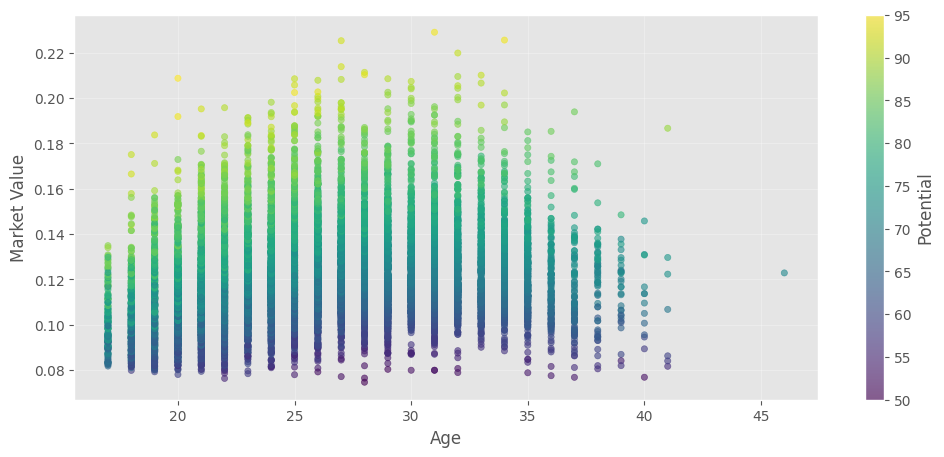

In [117]:
plt.figure(figsize=(12, 5))

df_plot = df_filtered[df_filtered['market_value'] != 0]

scatter = plt.scatter(df_plot['age'], df_plot['market_value'],
                      c=df_plot['potential'], cmap='viridis', alpha=0.6, s=20)

plt.xlabel('Age')
plt.ylabel('Market Value')
plt.grid(True, alpha=0.3)
plt.colorbar(scatter, label='Potential')

plt.show()

In [118]:
median_value_by_overall = df_filtered.groupby('overall_rating')['value_euro'].median()

# Compare each player's value to others with similar overall rating
df_filtered['relative_market_value'] = df_filtered.apply(
    lambda x: x['value_euro'] / median_value_by_overall.get(x['overall_rating'], 1)
    if x['overall_rating'] in median_value_by_overall else 1, axis=1
)

### 5. Athletic Potential Index

Measure of physical and technical attributes that translate to game impact

In [119]:
df_filtered['athletic_potential_index'] = (
    df_filtered['acceleration'] * 0.15 +
    df_filtered['sprint_speed'] * 0.15 +
    df_filtered['agility'] * 0.1 +
    df_filtered['shot_power'] * 0.2 +
    df_filtered['long_shots'] * 0.15 +
    df_filtered['stamina'] * 0.15 +
    df_filtered['dribbling'] * 0.1
)

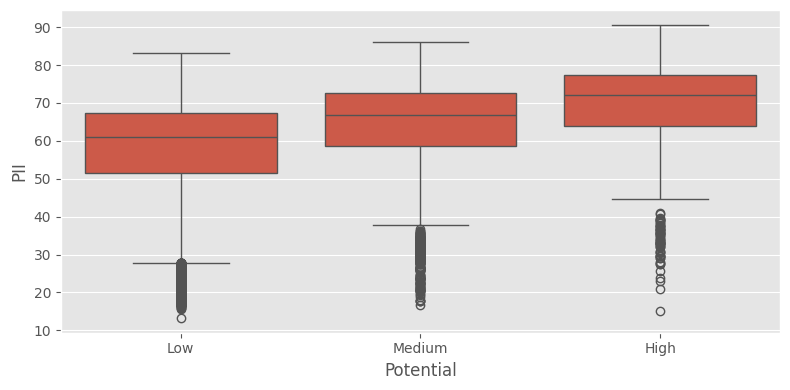

In [120]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (8, 4)

bins = [0, 76, 82, 100]
labels = ['Low', 'Medium', 'High']
df_filtered['potential_category'] = pd.cut(df_filtered['potential'], bins=bins, labels=labels)

sns.boxplot(x='potential_category', y='athletic_potential_index', data=df_filtered)
plt.xlabel('Potential')
plt.ylabel('PII')
plt.tight_layout()

### 6. Skill to Price

Technical quality to price ratio

In [121]:
# Calculate overall technical skill level
df_filtered['skill_level'] = (
    0.25 * df_filtered['ball_control'] +
    0.25 * df_filtered['composure'] +
    0.15 * df_filtered['vision'] +
    0.15 * df_filtered['short_passing'] +
    0.10 * df_filtered['agility'] +
    0.10 * df_filtered['acceleration']
)

df_filtered['skill_to_price'] = (
    df_filtered['skill_level'] / (df_filtered['value_euro'] / 1_000_000) # Value in Millions
)

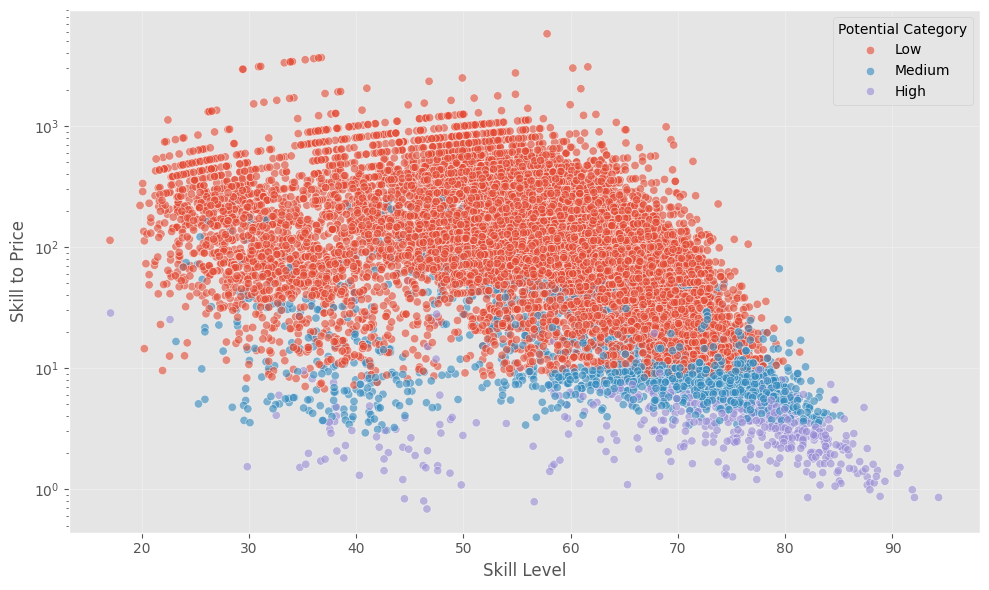

In [122]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='skill_level', y='skill_to_price', hue='potential_category', data=df_filtered, alpha=0.6)
plt.xlabel('Skill Level')
plt.yscale('log')
plt.ylabel('Skill to Price')
plt.grid(True, alpha=0.3)
plt.legend(title='Potential Category')
plt.tight_layout()
plt.show()

### 7. Overall Rating Aged

Current rating adjusted for age

In [123]:
df_filtered['overall_rating_aged'] = np.where(
    df_filtered['age'] <= 25,
    df_filtered['overall_rating'] * (0.9 + (26 - df_filtered['age']) * 0.08),# Youth bonus
    df_filtered['overall_rating'] * 0.9 # Standard rating for older players
)

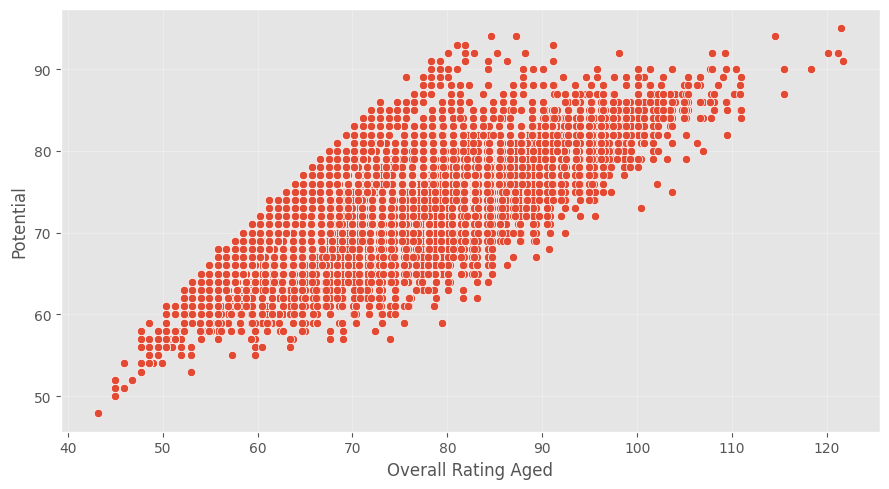

In [124]:
plt.figure(figsize=(9, 5))
sns.scatterplot(data=df_filtered, x='overall_rating_aged', y='potential')
plt.xlabel('Overall Rating Aged')
plt.ylabel('Potential')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Summary

In [125]:
FEATURES = [

    'growth_potential_index',
    'reaction_development',
    'role_quality',
    'market_value',
    'relative_market_value',
    'athletic_potential_index',
    'skill_to_price',
    'overall_rating_aged',

    'potential'

    ]

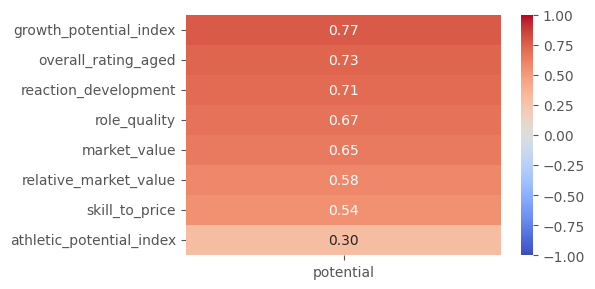

In [126]:
corr_with_potential = df_filtered[FEATURES].corr()[['potential']].abs().drop('potential').sort_values(by='potential', ascending=False)

plt.figure(figsize=(6, 3))
sns.heatmap(corr_with_potential, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt='.2f')
plt.tight_layout()
plt.show()

FEATURES.remove('potential')

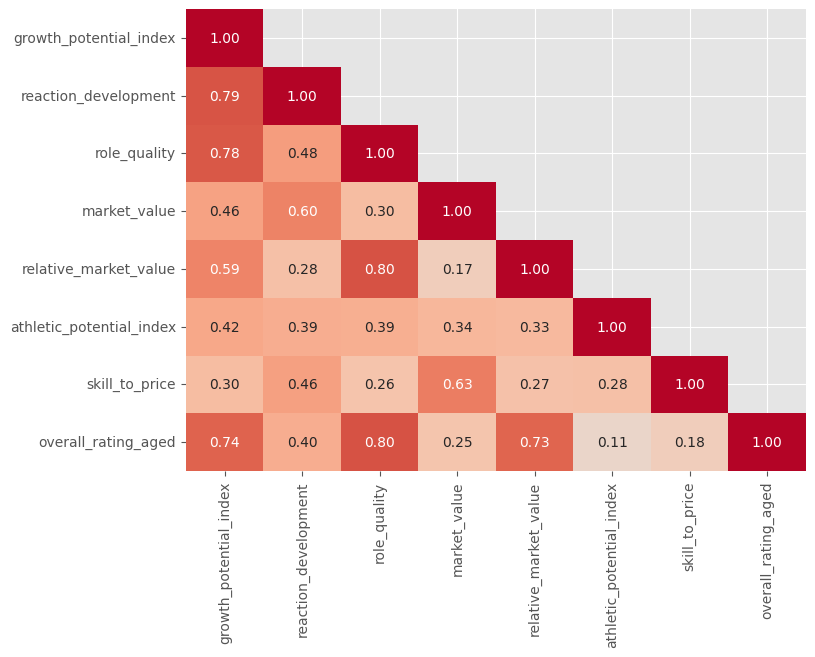

In [127]:
corr_with_potential = df_filtered[FEATURES].corr().abs()
mask = np.triu(np.ones_like(corr_with_potential, dtype=bool), k=1)

plt.figure(figsize=(8, 6))
sns.heatmap(
    corr_with_potential,
    mask=mask,
    annot=True,
    cmap='coolwarm',
    vmin=-1,
    vmax=1,
    fmt='.2f',
    cbar=False,
)
plt.show()

## Target

In [128]:
bins = [0, 76, 82, 100]
labels = [0, 1, 2]       # Low, Medium, High
df_filtered['target'] = pd.cut(df_filtered['potential'], bins=bins, labels=labels)


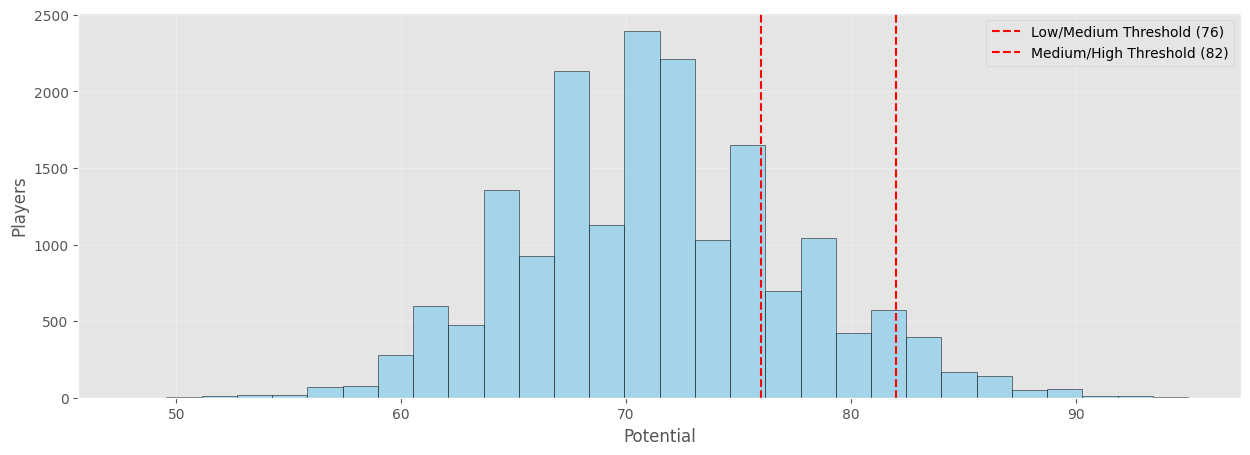

In [129]:
plt.figure(figsize=(15, 5))

plt.hist(df_filtered['potential'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(76, color='red', linestyle='--', label='Low/Medium Threshold (76)')
plt.axvline(82, color='red', linestyle='--', label='Medium/High Threshold (82)')
plt.xlabel('Potential')
plt.ylabel('Players')
plt.legend()
plt.grid(True, alpha=0.3)

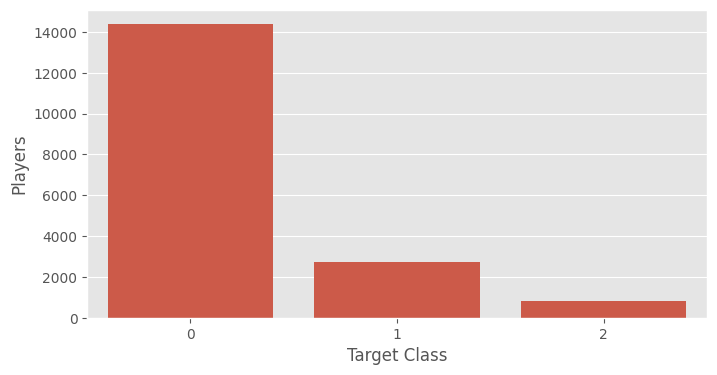

In [130]:
df_filtered['target_label'] = df_filtered['target']

sns.countplot(x='target_label', data=df_filtered)
plt.xlabel('Target Class')
plt.ylabel('Players')
plt.show()

# Data Processing

In [131]:
X = df_filtered[FEATURES].copy()
y = df_filtered['target']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=TRAIN_SIZE, random_state=S_RANDOM_STATE, stratify=y
)

In [132]:
BINARY_COLS = []
print(f"Number of binary cols: {len(BINARY_COLS)}")

NUMERICAL_COLS = [col for col in X.columns if X[col].dtype in ['float64', 'int64']]
print(f"Number of numerical cols: {len(NUMERICAL_COLS)}")

CATEGORICAL_COLS = [col for col in X.columns if col not in NUMERICAL_COLS]
print(f"Number of categorical cols: {len(CATEGORICAL_COLS)}")

Number of binary cols: 0
Number of numerical cols: 8
Number of categorical cols: 0


In [133]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())
])

categorical_transformer = SimpleImputer(strategy='most_frequent')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, NUMERICAL_COLS),
        ('cat', categorical_transformer, CATEGORICAL_COLS),
    ],
    verbose=False,
)

In [134]:
# Preprocessing
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Model

In [135]:
model = RandomForestClassifier(
    # MODEL STRUCTURAL PARAMETERS
    n_estimators=400,              # >100 for stability (<500 for performances)
    max_depth=None,                # Theory: no pruning. Risk: overfitting, but controlled by other params

    # OVERFITTING CONTROL PARAMETERS
    min_samples_leaf=5,            # Balance: <5 risks overfitting, >10 may underfit minority classes
    min_samples_split=4,           # Prevents splits on tiny samples; <4 unstable, >8 too restrictive

    # RANDOMIZATION PARAMETERS
    max_features=0.7,              # Balance: sqrt≈0.35 too random, 1.0 reduces diversity, 0.7 optimal

    # ALGORITHMIC PARAMETERS
    criterion='entropy',           # Often superior to 'gini' for multi-class; measures information gain
    bootstrap=True,                # Core RF principle: sampling with replacement for ensemble diversity
    oob_score=True,                # Free validation: ~1/3 samples never seen by each tree

    # WEIGHTS
    class_weight={0: 1.0,          # Baseline for majority class (3595 samples)
                  1: 3,            # 3x weight: balances 5:1 ratio (3595:684)
                  2: 7.5},         # 7.5x weight: balances 17:1 ratio (3595:210)

    # TECHNICAL PARAMETERS
    random_state=M_RANDOM_STATE,   # Reproducibility: essential for debugging and comparison
    n_jobs=-1                      # Speed: use all CPU cores (RF is embarrassingly parallel)
)

In [136]:
# Training
model.fit(X_train_processed, y_train)

RandomForestClassifier(class_weight={0: 1.0, 1: 3, 2: 7.5}, criterion='entropy',
                       max_features=0.7, min_samples_leaf=5,
                       min_samples_split=4, n_estimators=400, n_jobs=-1,
                       oob_score=True, random_state=42)

# Model Evaluation

In [137]:
# Prediction
y_train_pred = model.predict(X_train_processed)
y_test_pred =  model.predict(X_test_processed)

In [138]:
train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred, average='macro')

# Overfitting gap
overfitting_gap = train_acc - test_acc

In [139]:
# Results output
print(f"Train Accuracy: {train_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"F1 Score (macro): {test_f1:.4f}")
print(f"Overfitting Gap: {overfitting_gap:.4f}")
print(f"OOB Score: {model.oob_score_:.4f}")

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))

Train Accuracy: 0.9825
Test Accuracy: 0.9519
F1 Score (macro): 0.8964
Overfitting Gap: 0.0306
OOB Score: 0.9511

Confusion Matrix:
[[3507   88    0]
 [  71  577   36]
 [   0   21  189]]

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      3595
           1       0.84      0.84      0.84       684
           2       0.84      0.90      0.87       210

    accuracy                           0.95      4489
   macro avg       0.89      0.91      0.90      4489
weighted avg       0.95      0.95      0.95      4489



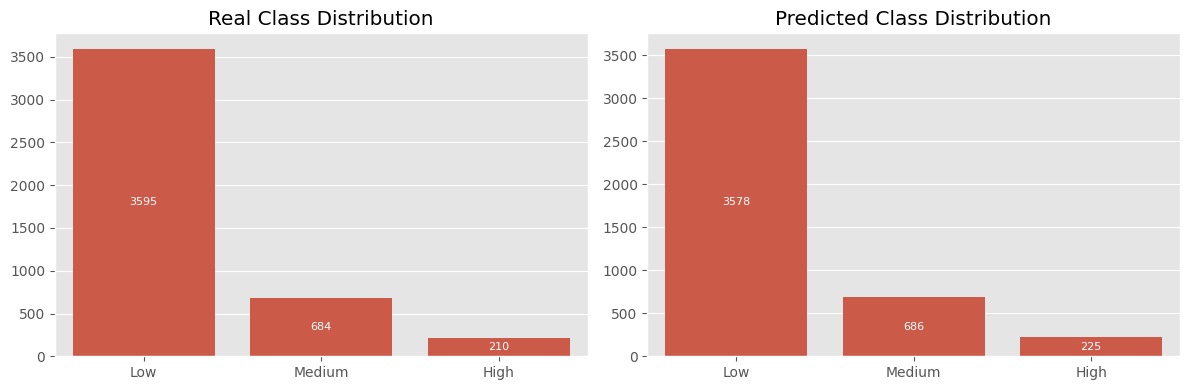

In [140]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

sns.countplot(x=y_test, ax=ax[0])
ax[0].set_title("Real Class Distribution")
ax[0].set_xticks([0, 1, 2])
ax[0].set_xticklabels(['Low', 'Medium', 'High'])
ax[0].set_xlabel("")
ax[0].set_ylabel("")

for p in ax[0].patches:
    height = p.get_height()
    ax[0].text(p.get_x() + p.get_width()/2, height/2, int(height),
               ha='center', va='center', color='white', fontsize=8)


sns.countplot(x=y_test_pred, ax=ax[1])
ax[1].set_title("Predicted Class Distribution")
ax[1].set_xticks([0, 1, 2])
ax[1].set_xticklabels(['Low', 'Medium', 'High'])
ax[1].set_xlabel("")
ax[1].set_ylabel("")


for p in ax[1].patches:
    height = p.get_height()
    ax[1].text(p.get_x() + p.get_width()/2, height/2, int(height),
               ha='center', va='center', color='white', fontsize=8)

plt.tight_layout()
plt.show()

In [141]:
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

feature_importance_df = pd.DataFrame({
    'Feature': [FEATURES[i] for i in indices],
    'Importance': [importances[i] for i in indices]
})

print("\nFeature Importance:")
print(feature_importance_df.head(20))



Feature Importance:
                    Feature  Importance
0    growth_potential_index    0.233176
1       overall_rating_aged    0.228259
2            skill_to_price    0.191034
3              market_value    0.129500
4     relative_market_value    0.105946
5      reaction_development    0.054349
6              role_quality    0.034895
7  athletic_potential_index    0.022842


# Submission

In [145]:
OUTPUT_PATH = "/content/"
my_submission = pd.DataFrame({
    "full_name": df_filtered.loc[y_test.index, "full_name"],
    "target": y_test_pred,
    "potential" : y_test
})
my_submission.to_csv(OUTPUT_PATH + "submission.csv", index=False)

In [143]:
OUTPUT_PATH = "/content/"

error_mask = y_test != y_test_pred
error_indices = y_test.index[error_mask]

df_errors = df_filtered.loc[error_indices].copy()
df_errors["true_target"] = y_test[error_mask]
df_errors["predicted_target"] = y_test_pred[error_mask]

df_errors.to_csv(OUTPUT_PATH + "submission_errors.csv", index=False)